In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, GRU
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import talib
import ta
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 23

np.random.seed(RANDOM_SEED)

2022-04-25 02:49:51.897449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/openmpi/lib:/usr/local/lib:/usr/lib:/usr/local/openmpi/lib:/usr/local/lib:/usr/lib:
2022-04-25 02:49:51.897475: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load the data from the source file

In [2]:
df = pd.read_csv('../data/BTC-USD-1h.csv', parse_dates=['time'])
df = df.rename(columns={'time':'Date', 'low':'Low', 'high':'High', 'open':'Open', 'close':'Close', 'volume':'Volume'})

# Prepare the TA indicators
df['EMA7'] = talib.EMA(df['Close'], timeperiod=7)
df['EMA30'] = talib.EMA(df['Close'], timeperiod=30)
df['EMA90'] = talib.EMA(df['Close'], timeperiod=90)
df['MACD'], MACDSIGNAL, MACDHIST = talib.MACD(df['Close'])
df['MFI'] = talib.MFI(df['High'], df['Low'], df['Close'], df['Volume'])
df['RSI'] = talib.RSI(df['Close'])
df['VWAP'] = ta.volume.VolumeWeightedAveragePrice(df['High'], df['Low'], df['Close'], df['Volume']).volume_weighted_average_price()
df['DEMA'] = talib.DEMA(df['Close'])

## Transform and normalize the data

In [3]:
SEQ_LEN=100
df_model = df.copy().drop('Date', axis=1).iloc[89:]
features = df_model.columns
scaler_pred = MinMaxScaler()
df_close = pd.DataFrame(df_model['Close'])
df_close = scaler_pred.fit_transform(df_close)
scaler = MinMaxScaler()
df_model = scaler.fit_transform(df_model)

# convert the prices into sequences
def preprocess(data, train_split, index_Close, sequence_length):
    
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    num_train = int(train_split * data.shape[0])
    
    X_train = x[:num_train, :, :]
    y_train = y[:num_train]
    
    X_test = x[num_train:, :, :]
    y_test = y[num_train:]
    
    return X_train, y_train, X_test, y_test, y

X_train, y_train, X_test, y_test, y = preprocess(df_model, train_split=0.9, index_Close=df.columns.get_loc('Close')-1, sequence_length=SEQ_LEN)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (7285, 100, 13)
X_test: (710, 100, 13)
y_train: (7285,)
y_test: (710,)


## Build the model

In [4]:
## Build the LSTM model

DROPOUT = 0.2

model = keras.Sequential()
model.add(Bidirectional(LSTM(512, bias_regularizer=keras.regularizers.l2(0.015), return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM(512, return_sequences=False)))
model.add(Dropout(rate=DROPOUT))
model.add(Dense(units=1))
model.add(Activation('LeakyReLU'))
model.summary()

2022-04-25 02:50:12.810144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/openmpi/lib:/usr/local/lib:/usr/lib:/usr/local/openmpi/lib:/usr/local/lib:/usr/lib:
2022-04-25 02:50:12.810171: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-25 02:50:12.810187: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-42-211): /proc/driver/nvidia/version does not exist
2022-04-25 02:50:12.810395: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate c

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 1024)        2154496   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 1024)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 1024)        6295552   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 100, 1024)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1024)             6295552   
 nal)                                                            
                                                        

In [5]:
## compile the model

model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

## Train the model

In [ ]:
## Train the model (run on the AWS server) due to the resources limitation of local machine

mc = ModelCheckpoint('../model/kbot_model_LSTM_1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

BATCH_SIZE = 32

history = model.fit(
    X_train, 
    y_train, 
    epochs=150, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.3,
    callbacks=[mc]
)

## Evaluate the model

23/23 [==============================] - 8s 307ms/step - loss: 5.1548e-05


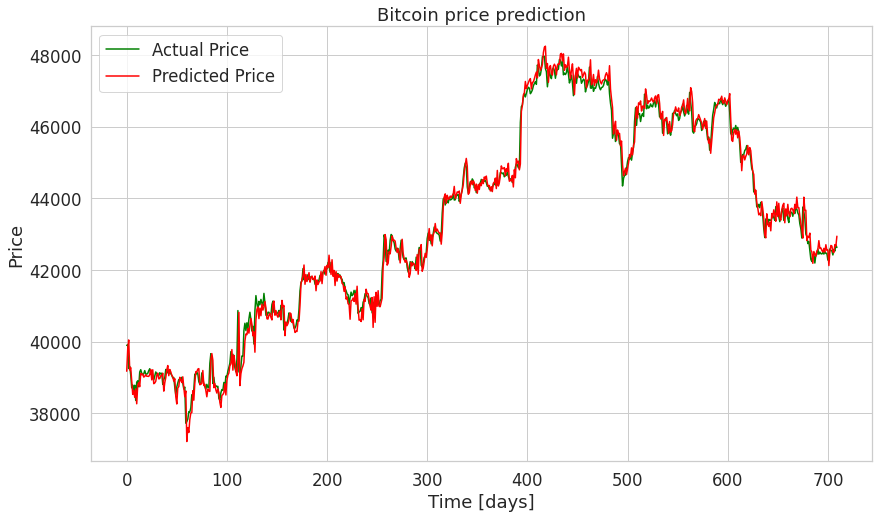

In [6]:
## Apply the model on test data set

model = load_model('../model/kbot_model_LSTM_1.h5')
model.evaluate(X_test, y_test)

y_pred_test = model.predict(X_test)

y_test_inverse = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_inverse = y_test_inverse[:,0]

y_pred_test_inverse = scaler_pred.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_test_inverse = y_pred_test_inverse[:,0]
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_pred_test_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

228/228 [==============================] - 73s 315ms/step - loss: 1.5290e-04


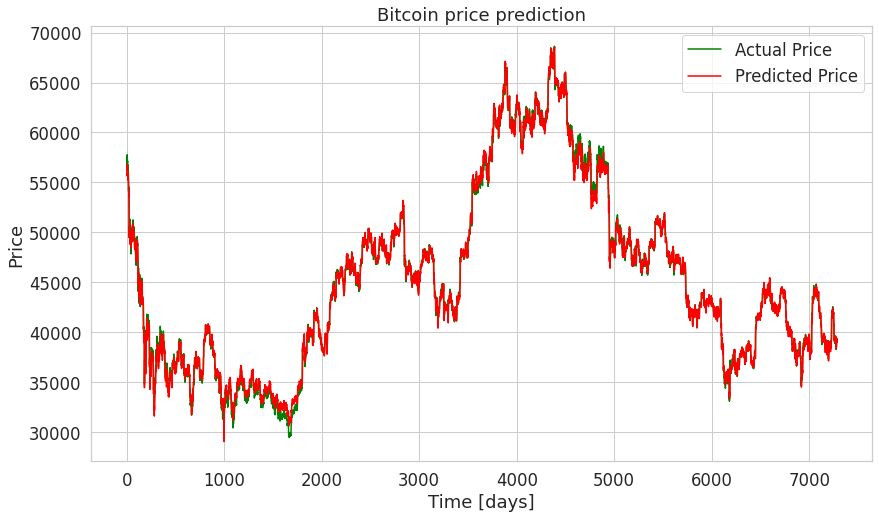

In [7]:
## Apply the model on train data set

model = load_model('../model/kbot_model_LSTM_1.h5')
model.evaluate(X_train, y_train)

y_pred_train = model.predict(X_train)

y_train_inverse = scaler_pred.inverse_transform(y_train.reshape(-1, 1))
y_train_inverse = y_train_inverse[:,0]

y_pred_train_inverse = scaler_pred.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_train_inverse = y_pred_train_inverse[:,0]
 
plt.plot(y_train_inverse, label="Actual Price", color='green')
plt.plot(y_pred_train_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [8]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train_inverse,y_pred_train_inverse)))
print("Train data MSE: ", mean_squared_error(y_train_inverse,y_pred_train_inverse))
print("Train data MAE: ", mean_absolute_error(y_train_inverse,y_pred_train_inverse))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test_inverse,y_pred_test_inverse)))
print("Test data MSE: ", mean_squared_error(y_test_inverse,y_pred_test_inverse))
print("Test data MAE: ", mean_absolute_error(y_test_inverse,y_pred_test_inverse))
print("-------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(y_train_inverse, y_pred_train_inverse))
print("Test data R2 score:", r2_score(y_test_inverse, y_pred_test_inverse))
print("-------------------------------------------------------------------------------------")
print("Train data Adj. R2 score:", 1 - (1-r2_score(y_train_inverse, y_pred_train_inverse))*(len(y_train_inverse)-1)/(len(y_train_inverse)-X_train.shape[1]-1))
print("Test data Adj. R2 score:", 1 - (1-r2_score(y_test_inverse, y_pred_test_inverse))*(len(y_test_inverse)-1)/(len(y_test_inverse)-X_train.shape[1]-1))

Train data RMSE:  483.00496357240803
Train data MSE:  233293.7948355832
Train data MAE:  352.86448464310223
-------------------------------------------------------------------------------------
Test data RMSE:  274.8333218903143
Test data MSE:  75533.35482126514
Test data MAE:  201.08360079225358
-------------------------------------------------------------------------------------
Train data R2 score: 0.9971042210015536
Test data R2 score: 0.9903749584415457
-------------------------------------------------------------------------------------
Train data Adj. R2 score: 0.9970639122738469
Test data Adj. R2 score: 0.9887944918473824
